In [ ]:
!pip install dowhy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 9.2 MB/s eta 0:00:00


**Finding the Root Cause of Elevated Latencies in a Microservice Architecture**

In this case study, we identify the root causes of “unexpected” observed latencies in cloud services that empower an online shop. We focus on the process of placing an order, which involves different services to make sure that the placed order is valid, the customer is authenticated, the shipping costs are calculated correctly, and the shipping process is initiated accordingly.
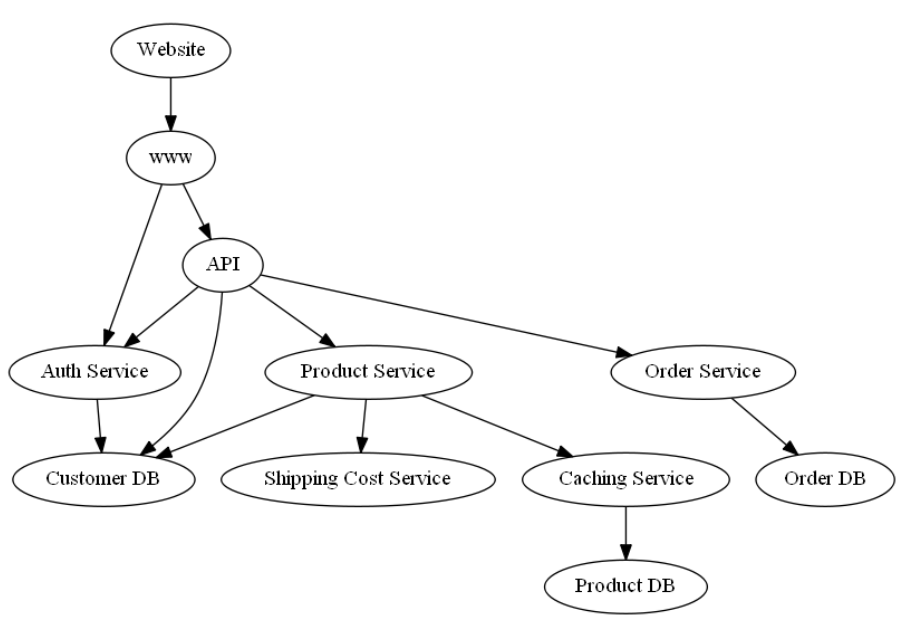

In [ ]:
#Let us load data with observed latencies of each node.
import pandas as pd

normal_data = pd.read_csv("rca_microservice_architecture_latencies.csv")
normal_data.head()

,Product DB,Customer DB,Order DB,Shipping Cost Service,Caching Service,Product Service,Auth Service,Order Service,API,www,Website
0,0.553608,0.057729,0.153977,0.120217,0.122195,0.391738,0.399664,0.710525,2.103962,2.580403,2.971071
1,0.053393,0.239560,0.297794,0.142854,0.275471,0.545372,0.646370,0.991620,2.932192,3.804571,3.895535
2,0.023860,0.300044,0.042169,0.125017,0.152685,0.574918,0.672228,0.964807,3.106218,4.076227,4.441924
3,0.118598,0.478097,0.042383,0.143969,0.222720,0.618129,0.638179,0.938366,3.217643,4.043560,4.334924
4,0.524901,0.078031,0.031694,0.231884,0.647452,1.081753,0.388506,0.711937,2.793605,3.215307,3.255062


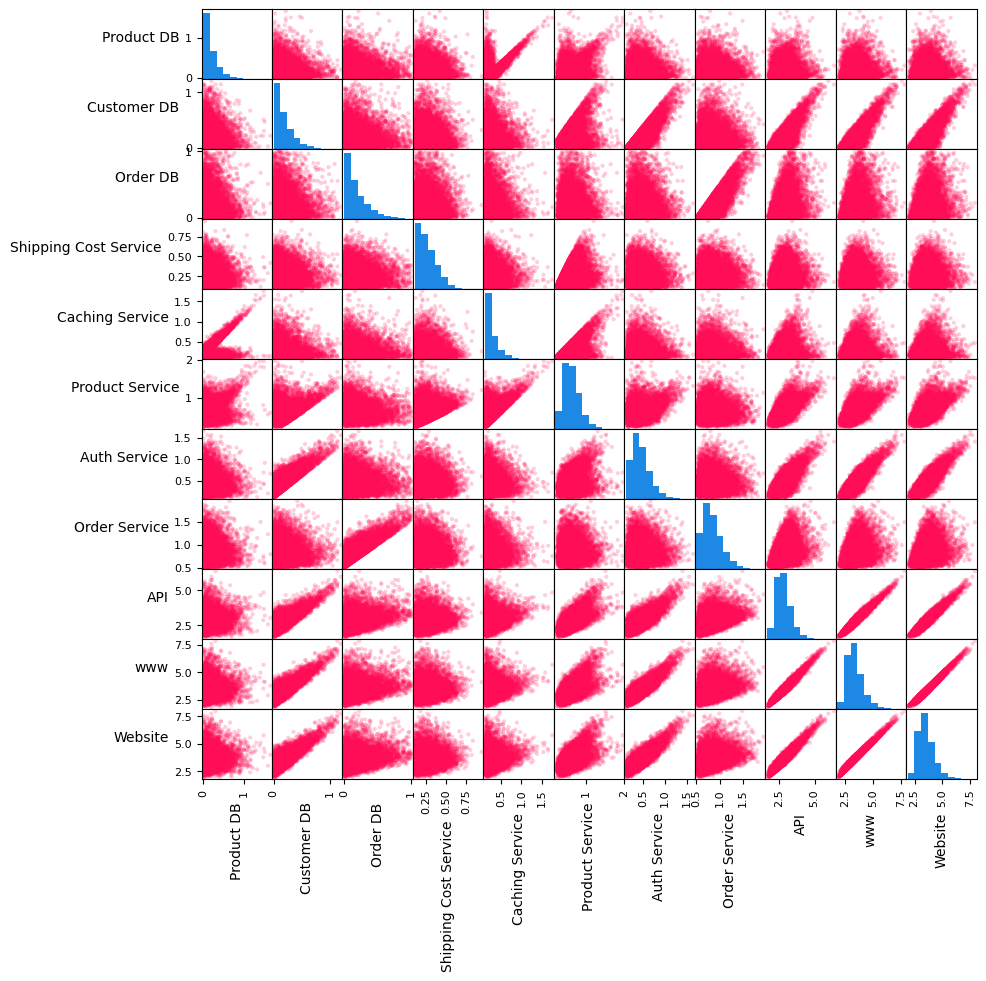

In [ ]:
#Let us also take a look at the pair-wise scatter plots and histograms of the variables.
axes = pd.plotting.scatter_matrix(normal_data, figsize=(10, 10), c='#ff0d57', alpha=0.2, hist_kwds={'color':['#1E88E5']});
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

The histograms of services without a dependency, namely Customer DB, Product DB, Order DB and Shipping Cost Service, have shapes similar to one half of a Gaussian distribution. The scatter plots of various pairs of variables (e.g., API and www, www and Website, Order Service and Order DB) show linear relations.

**Setting up the causal model**

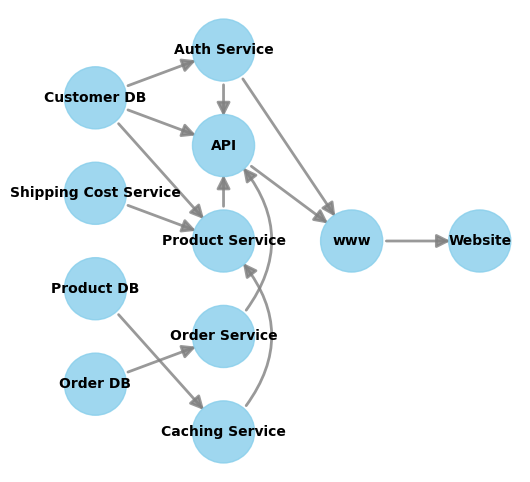

In [ ]:
import networkx as nx
from dowhy import gcm
from dowhy.utils import plot, bar_plot

causal_graph = nx.DiGraph([('www', 'Website'),
                           ('Auth Service', 'www'),
                           ('API', 'www'),
                           ('Customer DB', 'Auth Service'),
                           ('Customer DB', 'API'),
                           ('Product Service', 'API'),
                           ('Auth Service', 'API'),
                           ('Order Service', 'API'),
                           ('Shipping Cost Service', 'Product Service'),
                           ('Caching Service', 'Product Service'),
                           ('Product DB', 'Caching Service'),
                           ('Customer DB', 'Product Service'),
                           ('Order DB', 'Order Service')])

plot(causal_graph, figure_size=[6,6])

In particular, we assign half-Normal distributions to the root nodes (i.e., Customer DB, Product DB, Order DB and Shipping Cost Service). For non-root nodes, we assign linear additive noise models (which scatter plots of many parent-child pairs indicate) with empirical distribution of noise terms.

In [ ]:
from scipy.stats import halfnorm

causal_model = gcm.StructuralCausalModel(causal_graph)

for node in causal_graph.nodes:
    if len(list(causal_graph.predecessors(node))) > 0:
        causal_model.set_causal_mechanism(node, gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
    else:
        causal_model.set_causal_mechanism(node, gcm.ScipyDistribution(halfnorm)) # y = f(x)+N

Alternatively, we can also automate this if we don’t have prior knowledge or are not familiar with the statistical implications:

In [ ]:
gcm.auto.assign_causal_mechanisms(causal_model, normal_data)

In [ ]:
gcm.fit(causal_model, normal_data)

Fitting causal mechanism of node Order DB: 100%|██████████| 11/11 [00:00<00:00, 39.00it/s]


**Scenario 1: Observing a single outlier**

Suppose we get an alert from our system where a customer experienced an unusually high latency when an order is placed. Our task is now to investigate this issue and to find the root cause of this behaviour.

In [ ]:
outlier_data = pd.read_csv("rca_microservice_architecture_anomaly.csv")
outlier_data

,Product DB,Customer DB,Order DB,Shipping Cost Service,Caching Service,Product Service,Auth Service,Order Service,API,www,Website
0,0.493145,0.180896,0.192593,0.197001,2.130865,2.48584,0.533847,1.132151,4.85583,5.522179,5.572588


We are interested in the increased latency of Website which the customer directly experienced.

In [ ]:
outlier_data.iloc[0]['Website']-normal_data['Website'].mean()

2.0089554506421723

or this customer, Website was roughly 2 seconds slower than for other customers on average. Why?

To answer why Website was slower for this customer, we attribute the outlier latency at Website to upstream services in the causal graph. We refer the reader to Janzing et al., 2019 for scientific details behind this API. We will calculate a 95% bootstrapped confidence interval of our attributions. In particular, we learn the causal models from a random subset of normal data and attribute the target outlier score using those models, repeating the process 10 times. This way, the confidence intervals we report account for (a) the uncertainty of our causal models as well as (b) the uncertainty in the attributions due to the variance in the samples drawn from those causal models.

In [ ]:
gcm.config.disable_progress_bars() # to disable print statements when computing Shapley values

median_attribs, uncertainty_attribs = gcm.confidence_intervals(
    gcm.fit_and_compute(gcm.attribute_anomalies,
                        causal_model,
                        normal_data,
                        target_node='Website',
                        anomaly_samples=outlier_data),
    num_bootstrap_resamples=10)

Let us visualize the attributions along with their uncertainty in a bar plot.

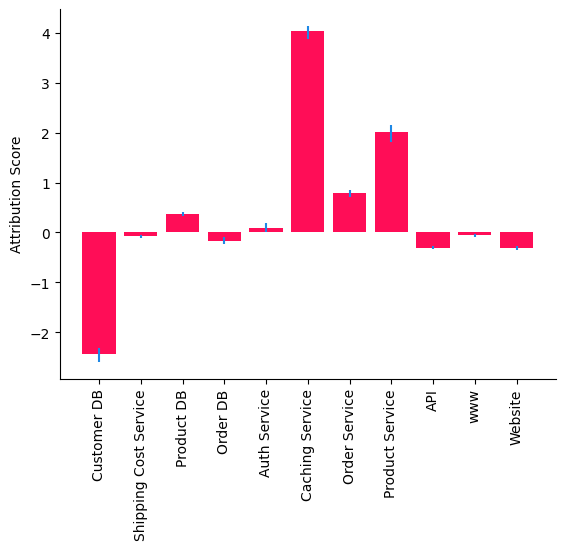

In [ ]:
bar_plot(median_attribs, uncertainty_attribs, 'Attribution Score')

The attributions indicate that Caching Service is the main driver of high latency in Website which is expected as we perturb the causal mechanism of Caching Service to generate an outlier latency in Website (see Appendix below). Attributions to Customer DB and Product Service can be explained by misspecification of causal models. First, some of the parent-child relationships in the causal graph are non-linear (by looking at the scatter matrix). Second, the parent child-relationship between Caching Service and Product DB seems to indicate two mechanisms. This could be due to an unobserved binary variable (e.g., Cache hit/miss) that has a multiplicative effect on Caching Service. An additive noise cannot capture the multiplicative effect of this unobserved variable.

**Scenario 2: Observing permanent degradation of latencies**

In [ ]:
outlier_data = pd.read_csv("rca_microservice_architecture_anomaly_1000.csv")
outlier_data.head()

,Product DB,Customer DB,Order DB,Shipping Cost Service,Caching Service,Product Service,Auth Service,Order Service,API,www,Website
0,0.140874,0.270117,0.021619,0.159421,2.201327,2.453859,0.958687,0.572128,4.921074,5.891927,5.937950
1,0.160903,0.008235,0.182182,0.114568,2.105901,2.259432,0.325054,0.683030,4.009969,4.373290,4.418746
2,0.013300,0.127177,0.591904,0.112362,2.160395,2.278189,0.645109,1.097460,4.915487,5.578015,5.708616
3,1.317167,0.145850,0.094301,0.401206,3.505417,3.622197,0.502680,0.880008,5.652773,6.265665,6.356730
4,0.699519,0.425039,0.233269,0.572897,2.931482,3.062255,0.598265,0.885846,5.585744,6.266662,6.346390


In [ ]:
outlier_data['Website'].mean() - normal_data['Website'].mean()

1.932364885302245

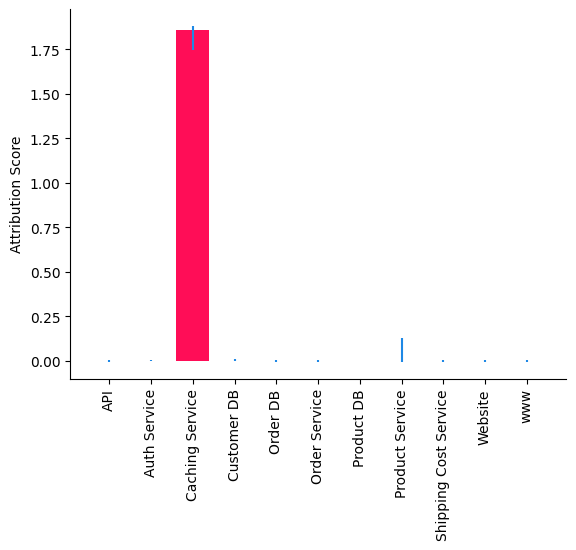

In [ ]:
import numpy as np

median_attribs, uncertainty_attribs = gcm.confidence_intervals(
    lambda : gcm.distribution_change(causal_model,
                                     normal_data.sample(frac=0.6),
                                     outlier_data.sample(frac=0.6),
                                     'Website',
                                     difference_estimation_func=lambda x, y: np.mean(y) - np.mean(x)),
    num_bootstrap_resamples = 10)

bar_plot(median_attribs, uncertainty_attribs, 'Attribution Score')

**Scenario 3: Simulating the intervention of shifting resources**

Next, let us imagine a scenario where permanent degradation has happened as in scenario 2 and we’ve successfully identified Caching Service as the root cause. Furthermore, we figured out that a recent deployment of the Caching Service contained a bug that is causing the overloaded hosts. A proper fix must be deployed, or the previous deployment must be rolled back. But, in the meantime, could we mitigate the situation by shifting over some resources from Shipping Service to Caching Service? And would that help? Before doing it in reality, let us simulate it first and see whether it improves the situation.

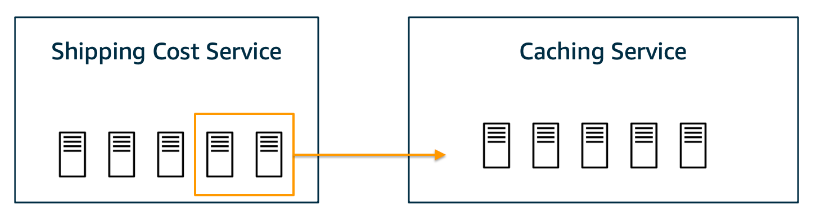

Let’s perform an intervention where we say we can reduce the average time of Caching Service by 1s. But at the same time we buy this speed-up by an average slow-down of 2s in Shipping Cost Service.

In [ ]:
median_mean_latencies, uncertainty_mean_latencies = gcm.confidence_intervals(
    lambda : gcm.fit_and_compute(gcm.interventional_samples,
                                 causal_model,
                                 outlier_data,
                                 interventions = {
                                    "Caching Service": lambda x: x-1,
                                    "Shipping Cost Service": lambda x: x+2
                                 },
                                 observed_data=outlier_data)().mean().to_dict(),
    num_bootstrap_resamples=10)

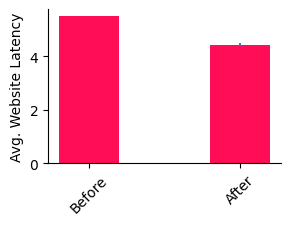

In [ ]:
avg_website_latency_before = outlier_data.mean().to_dict()['Website']
bar_plot(dict(before=avg_website_latency_before, after=median_mean_latencies['Website']),
                  dict(before=np.array([avg_website_latency_before, avg_website_latency_before]), after=uncertainty_mean_latencies['Website']),
                  ylabel='Avg. Website Latency',
                  figure_size=(3, 2),
                  bar_width=0.4,
                  xticks=['Before', 'After'],
                  xticks_rotation=45)